In [21]:
import os
import glob
import cv2
import numpy as np
import hashlib

In [17]:
#Função para calcular uma hash para cada imagem
def calculate_hash(img):
    return hashlib.sha256(img).hexdigest()

# Função para carregar imagens de uma pasta
def load_images_from_folder(folder):
    images = []
    hashes=[]
    path=[]
    #Considera todas as pastas dentro do diretorio que se encontra
    disease_folder=glob.glob(os.path.join(folder, "*"))
    for files in disease_folder:
        print(f"A iterar {files}")
        for filename in os.listdir(files):
            try:
                img = cv2.imread(os.path.join(files, filename),cv2.IMREAD_UNCHANGED)
                if img is not None:
                    images.append(img)
                    path.append(filename)
                    hash_imagem=calculate_hash(img)
                    hashes.append(hash_imagem)
                else:
                    print(f"Não foi possível carregar a imagem: {filename}")
            except Exception as e:
                    print(f"Erro ao carregar a imagem {filename}: {str(e)}")
    print("Fim do carregamento de imagens")            
    return images, hashes, path

# Diretório onde estão as imagens
#train_folder = '/Users/hugopereira/DatasetMEIA/train'
#test_folder = '/Users/hugopereira/DatasetMEIA/test'
train_folder = 'C:/Dev/DatasetMEIA/train'
test_folder = 'C:/Dev/DatasetMEIA/test'
if os.path.exists(train_folder):
    print("O caminho existe e está acessível.")
else:
    print("O caminho não existe ou não está acessível.")

# Carregar imagens de treino e teste
train_images, train_hashes, train_names = load_images_from_folder(train_folder)
test_images, test_hashes, test_names = load_images_from_folder(test_folder)

# Verificar se as imagens foram carregadas corretamente
print(f"Número de imagens de treino carregadas: {len(train_images)}")
print(f"Número de imagens de teste carregadas: {len(test_images)}")

O caminho existe e está acessível.
A iterar C:/Dev/DatasetMEIA/train\Atopic Dermatitis Photos
A iterar C:/Dev/DatasetMEIA/train\Lupus and other Connective Tissue diseases
A iterar C:/Dev/DatasetMEIA/train\Melanoma Skin Cancer Nevi and Moles
A iterar C:/Dev/DatasetMEIA/train\Psoriasis pictures Lichen Planus and related diseases
A iterar C:/Dev/DatasetMEIA/train\Urticaria Hives
Fim do carregamento de imagens
A iterar C:/Dev/DatasetMEIA/test\Atopic Dermatitis Photos
A iterar C:/Dev/DatasetMEIA/test\Lupus and other Connective Tissue diseases
A iterar C:/Dev/DatasetMEIA/test\Melanoma Skin Cancer Nevi and Moles
A iterar C:/Dev/DatasetMEIA/test\Psoriasis pictures Lichen Planus and related diseases
A iterar C:/Dev/DatasetMEIA/test\Urticaria Hives
Fim do carregamento de imagens
Número de imagens de treino carregadas: 2989
Número de imagens de teste carregadas: 749


In [26]:
#Verificar se existe imagens duplicadas
def find_duplicate_hashes(caminhos_imagens, hashes_imagens):
    duplicate=[]
    check_hashes=set()
    for i, hash_atual in enumerate(hashes_imagens):
        if hash_atual not in check_hashes:
            check_hashes.add(hash_atual)
            for j in range(i + 1, len(hashes_imagens)):
                if hash_atual == hashes_imagens[j]:
                    duplicate.append((caminhos_imagens[i], caminhos_imagens[j]))

    return duplicate

def see_duplicate(duplicate, folder):
    if len(duplicate)>0: 
        print(f"Imagens duplicadas encontradas no conjunto {folder}:")
        print(duplicate)
    else:
        print(f"Não foram encontradas imagens duplicadas no conjunto {folder}.")

duplicate_train=find_duplicate_hashes(train_names, train_hashes)
see_duplicate(duplicate_train,"treino")
print("-------------------------------------")
duplicate_test=find_duplicate_hashes(test_names, test_hashes)
see_duplicate(duplicate_test, "teste")



Imagens duplicadas encontradas no conjunto treino:
[('05atopicChild0828062.jpg', '05atopicWrist0828064.jpg'), ('05AtopicDermHand.jpg', '05AtopicHand.jpg'), ('05AtopicDermHand.jpg', '05AtopicHandq.jpg'), ('05AtopicDermHand1.jpg', '05AtopicHand1q.jpg'), ('05AtopicWrist.jpg', '05AtopicWristq.jpg'), ('05pityriasisAlba94-GP3.jpg', '05pityriasisAlba94.jpg'), ('chilblains-perniosis-32.jpg', 'chilblains-perniosis-38.jpg'), ('lupus-chronic-cutaneous-10.jpg', 'lupus-chronic-cutaneous-11.jpg'), ('lupus-chronic-cutaneous-12.jpg', 'lupus-chronic-cutaneous-13.jpg'), ('morphea-35.jpg', 'morphea-36.jpg'), ('atypical-nevi-22.jpg', 'melanocytic-nevi-58.jpg'), ('atypical-nevi-24.jpg', 'melanocytic-nevi-19.jpg'), ('blue-nevus-11.jpg', 'blue-nevus-12.jpg'), ('congenital-nevus-26.jpg', 'congenital-nevus-27.jpg'), ('congenital-nevus-28.jpg', 'congenital-nevus-29.jpg'), ('congenital-nevus-46.jpg', 'melanocytic-nevi-7.jpg'), ('congenital-nevus-47.jpg', 'congenital-nevus-48.jpg'), ('malignant-melanoma-11.jpg', 

In [40]:
# Redimensionar imagens
def resize_images(images, new_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return resized_images

# Tamanho desejado para as imagens (224x224)
new_size = (224, 224)

# Redimensionar imagens de treino e teste
train_images_resized = resize_images(train_images, new_size)
test_images_resized = resize_images(test_images, new_size)

# Verificar se as imagens foram redimensionadas corretamente
print(f"Número de imagens de treino redimensionadas: {len(train_images_resized)}")
print(f"Número de imagens de teste redimensionadas: {len(test_images_resized)}")

Número de imagens de treino redimensionadas: 2989
Número de imagens de teste redimensionadas: 749


In [41]:
# Converter listas de imagens para arrays numpy
train_images_array = np.array(train_images_resized)
test_images_array = np.array(test_images_resized)

# Verificar se as imagens foram convertidas corretamente para arrays numpy
print(f"Número de imagens de treino arrays numpy: {len(train_images_array)}")
print(f"Número de imagens de teste arrays numpy: {len(test_images_array)}")

Número de imagens de treino arrays numpy: 2989
Número de imagens de teste arrays numpy: 749


In [43]:
# Verificar as formas dos arrays de imagens
print(f"Shape do array de imagens de treino: {train_images_array.shape}")
print(f"Shape do array de imagens de teste: {test_images_array.shape}")

Shape do array de imagens de treino: (2989, 224, 224, 3)
Shape do array de imagens de teste: (749, 224, 224, 3)


In [44]:
# Normalização
def normalize_images(images):
    normalized_images = []
    for img in images:
        normalized_img = img / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]
        normalized_images.append(normalized_img)
    return np.array(normalized_images)

# Normalizar imagens de treinamento e teste
train_images_normalized = normalize_images(train_images_resized)
test_images_normalized = normalize_images(test_images_resized)

In [45]:
#Augmentation

from keras.preprocessing.image import ImageDataGenerator

# Criar um gerador de imagens com técnicas de aumento de dados
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Redimensionar imagens para o formato esperado pelo ImageDataGenerator
train_images_normalized_resized = train_images_normalized.reshape(-1, new_size[0], new_size[1], 3)

# Ajustar o gerador às imagens de treinamento
datagen.fit(train_images_normalized_resized)

In [52]:
# Balanceamento de classes

from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator

#train_labels = [
    #"Lupus and other Connective Tissue diseases",
    #"Atopic Dermatitis Photos",
    #"Melanoma Skin Cancer Nevi and Moles",
    #"Psoriasis pictures Lichen Planus and related diseases",
    #"Urticaria Hives"
#]

# Converter labels para números inteiros
label_to_integer = {label: idx for idx, label in enumerate(train_labels)}
train_labels_int = [label_to_integer[label] for label in train_labels]

# Aplicar oversampling
oversampler = RandomOverSampler()
train_images_balanced, train_labels_balanced = oversampler.fit_resample(train_images_augmented.reshape(len(train_images_augmented), -1), train_labels_int)


In [48]:
from collections import Counter

# Contagem de instâncias por classe antes do balanceamento
counter_before = Counter(train_labels)
print("Contagem de instâncias por classe antes do balanceamento:", counter_before)

# Contagem de instâncias por classe depois do balanceamento
counter_after = Counter(train_labels_balanced)
print("Contagem de instâncias por classe depois do balanceamento:", counter_after)


Contagem de instâncias por classe antes do balanceamento: Counter({'Lupus and other Connective Tissue diseases': 1, 'Atopic Dermatitis Photos': 1, 'Melanoma Skin Cancer Nevi and Moles': 1, 'Psoriasis pictures Lichen Planus and related diseases': 1, 'Urticaria Hives': 1})
Contagem de instâncias por classe depois do balanceamento: Counter({0: 1, 1: 1, 2: 1, 3: 1, 4: 1})


In [49]:
import numpy as np

# Verificar os rótulos únicos em train_labels e train_labels_balanced
unique_labels = np.unique(train_labels)
unique_labels_balanced = np.unique(train_labels_balanced)

print("Rótulos únicos antes do balanceamento:", unique_labels)
print("Rótulos únicos depois do balanceamento:", unique_labels_balanced)


Rótulos únicos antes do balanceamento: ['Atopic Dermatitis Photos' 'Lupus and other Connective Tissue diseases'
 'Melanoma Skin Cancer Nevi and Moles'
 'Psoriasis pictures Lichen Planus and related diseases' 'Urticaria Hives']
Rótulos únicos depois do balanceamento: [0 1 2 3 4]


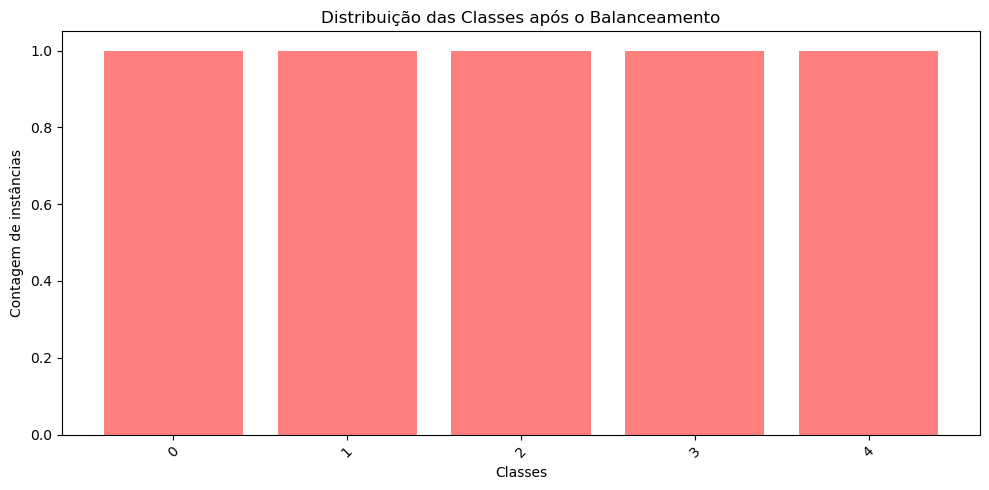

In [53]:
import matplotlib.pyplot as plt
from collections import Counter

# Contagem de instâncias por classe depois do balanceamento
counter_after = Counter(train_labels_balanced)
labels_after, counts_after = zip(*sorted(counter_after.items()))  # Ordenando os rótulos e contagens

# Gráfico de barras depois do balanceamento
plt.figure(figsize=(10, 5))
plt.bar(labels_after, counts_after, color='red', alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('Contagem de instâncias')
plt.title('Distribuição das Classes após o Balanceamento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [58]:
# Guardar o data-set pre-processado

# Guardar imagens pré-processadas e rótulos em arquivos NumPy
np.save('train_images.npy', train_images_balanced)
np.save('train_labels.npy', train_labels_balanced)
np.save('test_images.npy', test_images_normalized)
#np.save('test_labels.npy', test_labels)